## Prerequisite
### Dataset
Full dataset(~ 25GB, from Eos on lxplus)
```bash
cp /eos/user/w/woodson/img224_all/img224_all.tar .
```

### Custom weights

floating point: https://www.dropbox.com/sh/htjhdbaanp2yww2/AABcBx6MEg-73rK8X-ftPGVla?dl=0    
quantized: https://www.dropbox.com/sh/1nt66wm8zllaca2/AABEYnx9npgU_suN0Mulbzdta?dl=0 

### lib 
azureml-contrib-brainwave 
```bash
pip install tensorflow==1.15
pip install keras
pip intsall tables
pip install sklearn
pip install matplotlib
pip install azureml-contrib-brainwave
```

note: ResNet50 not longer used parameter 'custom_weights_directory'    
see：https://docs.microsoft.com/en-us/python/api/azureml-accel-models/azureml.accel.models.resnet50?view=azure-ml-py      
conflict with https://github.com/nhanvtran/MachineLearningNotebooks/blob/44aa70b61409be7ba7ccacd3f3232d2131e20dec/project-brainwave/utils.py#L130


### Useful links
project brainwave:     
https://github.com/nhanvtran/MachineLearningNotebooks/tree/nvt/bwcustomweights-validate/project-brainwave 

notebooks from Tom:    
https://github.com/LouYu2015/aws-fpga-top-tagging-notebooks

Xilinx ML suite:
https://github.com/Xilinx/ml-suite/tree/master/examples/tensorflow

## Convert h5 to pb(quantized)

In [ ]:
import os,sys
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf
import numpy as np
from keras import backend as K
import tables
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
%load_ext autoreload
%autoreload 2

In [ ]:
# Directories for models
custom_weights_dir_q = os.path.expanduser("weights-quantized-224x224-fixval-best-final/")
custom_weights_dir = os.path.expanduser("weights-floatingpoint-224x224-fixval-best/")
saved_model_dir = os.path.expanduser("models")

In [ ]:
# imported from utils 
# utils.py: https://github.com/nhanvtran/MachineLearningNotebooks/blob/nvt/bwcustomweights-validate/project-brainwave/utils.py
def count_events(train_files):
    import tables
    n_events = 0
    for train_file in train_files:
        f = tables.open_file(train_file, 'r')
        n_events += f.root.label.shape[0]
        f.close()
    return n_events

def preprocess_images(size=64):
    import tensorflow as tf
    # Create a placeholder for our incoming images
    in_height = size
    in_width = size
    in_images = tf.placeholder(tf.float32)
    in_images.set_shape([None, in_height, in_width, 3])
    
    # Resize those images to fit our featurizer
    if size==64:
        out_width = 224
        out_height = 224
        image_tensors = tf.image.resize_images(in_images, [out_height,out_width])
        image_tensors = tf.to_float(image_tensors)
    elif size==224:
        image_tensors = in_images
        
    return in_images, image_tensors

def construct_classifier():
    from keras.layers import Dropout, Dense, Flatten, Input
    from keras.models import Model
    from keras import backend as K
    import tensorflow as tf
    K.set_session(tf.get_default_session())
    
    FC_SIZE = 1024
    NUM_CLASSES = 2

    in_layer = Input(shape=(1, 1, 2048,),name='input_1')
    x = Dense(FC_SIZE, activation='relu', input_dim=(1, 1, 2048,),name='dense_1')(in_layer)
    x = Flatten(name='flatten_1')(x)
    preds = Dense(NUM_CLASSES, activation='softmax', input_dim=FC_SIZE, name='classifier_output')(x)
    
    model = Model(inputs = in_layer, outputs = preds)
    
    return model

def construct_model(quantized, saved_model_dir=None, starting_weights_directory=None, is_frozen=False, is_training=True, size=64):
    from azureml.contrib.brainwave.models import Resnet50, QuantizedResnet50
    import tensorflow as tf
    from keras import backend as K
    
    # Convert images to 3D tensors [width,height,channel]
    in_images, image_tensors = preprocess_images(size=size)

    # Construct featurizer using quantized or unquantized ResNet50 model
    
    if not quantized:
        featurizer = Resnet50(saved_model_dir, is_frozen=is_frozen, custom_weights_directory = starting_weights_directory)
    else:
        featurizer = QuantizedResnet50(saved_model_dir, is_frozen=is_frozen, custom_weights_directory = starting_weights_directory)
    
    features = featurizer.import_graph_def(input_tensor=image_tensors, is_training=is_training)
    
    # Construct classifier
    with tf.name_scope('classifier'):
        classifier = construct_classifier()
        preds = classifier(features)
    
    # Initialize weights
    sess = tf.get_default_session()
    tf.global_variables_initializer().run()
    
    if not is_frozen:
        featurizer.restore_weights(sess)
    
    if starting_weights_directory is not None:
        print("loading classifier weights from", starting_weights_directory+'/class_weights_best.h5')
        classifier.load_weights(starting_weights_directory+'/class_weights_best.h5')
        
    return in_images, image_tensors, features, preds, featurizer, classifier 



In [ ]:
import glob
# for 224x224:
datadir = "./"
data_size = 224 #image width/height
n_test_file = 1
test_files = glob.glob(os.path.join(datadir, 'test_file_*'))
n_test_events = count_events(test_files)
print("n_test_events =", n_test_events)

In [ ]:
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

with sess.as_default():
    print("Loading quantized model")
    in_images, image_tensors, features, preds, quantized_featurizer, classifier = construct_model(quantized=True, 
                                                                                                  saved_model_dir=saved_model_dir, 
                                                                                                  starting_weights_directory=custom_weights_dir_q, 
                                                                                                  is_training=False, 
                                                                                                  size=data_size)
    print(preds.name)
    pred_node_names = [preds.name[:-2]]

    K.set_learning_phase(0)
    saver = tf.train.Saver()
    tfoutpath=custom_weights_dir_q+'/tf.checkpoint'

    from tensorflow.python.framework import graph_util
    from tensorflow.python.framework import graph_io
    
    constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)

    f = 'constantgraph.pb.ascii'
    tf.train.write_graph(constant_graph, custom_weights_dir_q, f, as_text=True)
    print('saved the graph definition in ascii format at: ', os.path.join(custom_weights_dir_q, f))

    f = 'constantgraph.pb'
    tf.train.write_graph(constant_graph, custom_weights_dir_q, f, as_text=False)
    print('saved the graph definition in pb format at: ', os.path.join(custom_weights_dir_q, f))

    saver.save(sess, tfoutpath)
    

## Test weights (floating)

**Make sure to restart the kernel here if you are using jupynotebook!**

More details:    
https://github.com/LouYu2015/aws-fpga-top-tagging-notebooks/blob/master/Testing%20weights.ipynb    


In [1]:
import tensorflow as tf
from tensorflow.python.platform import gfile
def load_graph(sess, model_file_name, node_mapping={}):
    with gfile.GFile(model_file_name, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, node_mapping)

In [2]:
with tf.Session() as sess:
    # Create a placeholder for the input
    input_node = tf.placeholder(tf.float32, shape = [None, 224, 224, 3], name='Placeholder')
    graph_def = load_graph(sess=sess,
                           model_file_name='weights-floatingpoint-224x224-fixval-best/constantgraph.pb',
                           node_mapping={'Placeholder': input_node})
# Get the node for output
output_node = tf.get_default_graph().get_tensor_by_name("import/classifier/model_1/classifier_output/Softmax:0")

In [3]:
import numpy as np
with tf.Session() as sess:
    y = sess.run(output_node, feed_dict={input_node: np.zeros((2, 224, 224, 3))})

print(y)

[[0.00170122 0.9982988 ]
 [0.00170122 0.9982988 ]]


In [4]:
# imported from utils 
# utils.py: https://github.com/nhanvtran/MachineLearningNotebooks/blob/nvt/bwcustomweights-validate/project-brainwave/utils.py

def normalize_and_rgb(images): 
    import numpy as np
    #normalize image to 0-255 per image.
    image_sum = 1/np.sum(np.sum(images,axis=1),axis=-1)
    given_axis = 0
    # Create an array which would be used to reshape 1D array, b to have 
    # singleton dimensions except for the given axis where we would put -1 
    # signifying to use the entire length of elements along that axis  
    dim_array = np.ones((1,images.ndim),int).ravel()
    dim_array[given_axis] = -1
    # Reshape b with dim_array and perform elementwise multiplication with 
    # broadcasting along the singleton dimensions for the final output
    image_sum_reshaped = image_sum.reshape(dim_array)
    images = images*image_sum_reshaped*255

    # make it rgb by duplicating 3 channels.
    images = np.stack([images, images, images],axis=-1)
    
    return images

def count_events(train_files):
    import tables
    n_events = 0
    for train_file in train_files:
        f = tables.open_file(train_file, 'r')
        n_events += f.root.label.shape[0]
        f.close()
    return n_events



def chunks(files, chunksize, max_q_size=4, shuffle=True): 
    """Yield successive n-sized chunks from a and b.""" 
    import tables
    import numpy as np
    for train_file in files: 
        f = tables.open_file(train_file, 'r') 
        nrows = f.root.label.nrows
        for istart in range(0,nrows,max_q_size*chunksize):  
            a = np.array(f.root.img_pt[istart:istart+max_q_size*chunksize]) # Images 
            b = np.array(f.root.label[istart:istart+max_q_size*chunksize]) # Labels 
            if shuffle: 
                c = np.c_[a.reshape(len(a), -1), b.reshape(len(b), -1)] # shuffle within queue size
                np.random.shuffle(c)
                test_images = c[:, :a.size//len(a)].reshape(a.shape)
                test_labels = c[:, a.size//len(a):].reshape(b.shape)
            else:
                test_images = a
                test_labels = b
            for jstart in range(0,len(test_labels),chunksize): 
                yield normalize_and_rgb(test_images[jstart:jstart+chunksize].copy()),test_labels[jstart:jstart+chunksize].copy(), len(test_labels[jstart:jstart+chunksize].copy())  
        f.close()

def test_model(preds, in_images, test_files, chunk_size=64, shuffle=True):
    """Test the model"""
    import tensorflow as tf
    from keras import backend as K
    from keras.objectives import binary_crossentropy 
    import numpy as np
    from keras.metrics import categorical_accuracy
    from tqdm import tqdm
    
    in_labels = tf.placeholder(tf.float32, shape=(None, 2))
    
    cross_entropy = tf.reduce_mean(binary_crossentropy(in_labels, preds))
    accuracy = tf.reduce_mean(categorical_accuracy(in_labels, preds))
    auc = tf.metrics.auc(tf.cast(in_labels, tf.bool), preds)
   
    n_test_events = count_events(test_files)
    chunk_num = int(n_test_events/chunk_size)+1
    preds_all = []
    label_all = []
    
    sess = tf.Session()
    sess.run(tf.local_variables_initializer())
    
    avg_accuracy = 0
    avg_auc = 0
    avg_test_loss = 0
    is_training = tf.get_default_graph().get_tensor_by_name('import/is_training:0')
    n_current_events = 0
    for img_chunk, label_chunk, real_chunk_size in chunks(test_files, chunk_size, shuffle=shuffle):
        test_loss, accuracy_result, auc_result, preds_result = sess.run([cross_entropy, accuracy, auc, preds],
                        feed_dict={in_images: img_chunk,
                                   in_labels: label_chunk,
                                   K.learning_phase(): 0,
                                   is_training: False})
        avg_test_loss += test_loss * real_chunk_size / n_test_events
        avg_accuracy += accuracy_result * real_chunk_size / n_test_events
        avg_auc += auc_result[0]  * real_chunk_size / n_test_events 
        preds_all.extend(preds_result)
        label_all.extend(label_chunk)
        n_current_events += real_chunk_size
    
        print("test_loss = ", "{:.3f}".format(avg_test_loss*n_test_events/n_current_events), end="")
        print("Test Accuracy:", "{:.3f}".format(avg_accuracy*n_test_events/n_current_events), ", Area under ROC curve:", "{:.3f}".format(avg_auc*n_test_events/n_current_events))
    
    return avg_test_loss, avg_accuracy, avg_auc, np.asarray(preds_all).reshape(n_test_events,2), np.asarray(label_all).reshape(n_test_events,2)

In [5]:
loss, accuracy, auc, preds_test, test_labels = test_model(output_node, input_node, ['test_file_0.h5'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Using TensorFlow backend.



test_loss =  0.168Test Accuracy: 0.938 , Area under ROC curve: 0.000
test_loss =  0.270Test Accuracy: 0.906 , Area under ROC curve: 0.494
test_loss =  0.339Test Accuracy: 0.896 , Area under ROC curve: 0.651
test_loss =  0.290Test Accuracy: 0.906 , Area under ROC curve: 0.728
test_loss =  0.272Test Accuracy: 0.909 , Area under ROC curve: 0.776
test_loss =  0.251Test Accuracy: 0.911 , Area under ROC curve: 0.809
test_loss =  0.272Test Accuracy: 0.904 , Area under ROC curve: 0.832
test_loss =  0.268Test Accuracy: 0.908 , Area under ROC curve: 0.850
test_loss =  0.279Test Accuracy: 0.905 , Area under ROC curve: 0.863
test_loss =  0.267Test Accuracy: 0.908 , Area under ROC curve: 0.874
test_loss =  0.268Test Accuracy: 0.906 , Area under ROC curve: 0.883
test_loss =  0.275Test Accuracy: 0.902 , Area under ROC curve: 0.891
test_loss =  0.277Test Accuracy: 0.905 , Area under ROC curve: 0.897
test_loss =  0.277Test Accuracy: 0.905 , Area under ROC curve: 0.902
test_loss =  0.270Test Accuracy: 

test_loss =  0.316Test Accuracy: 0.894 , Area under ROC curve: 0.956
test_loss =  0.316Test Accuracy: 0.894 , Area under ROC curve: 0.956
test_loss =  0.314Test Accuracy: 0.894 , Area under ROC curve: 0.956
test_loss =  0.313Test Accuracy: 0.895 , Area under ROC curve: 0.956
test_loss =  0.313Test Accuracy: 0.895 , Area under ROC curve: 0.956
test_loss =  0.312Test Accuracy: 0.895 , Area under ROC curve: 0.956
test_loss =  0.311Test Accuracy: 0.895 , Area under ROC curve: 0.956
test_loss =  0.311Test Accuracy: 0.895 , Area under ROC curve: 0.956
test_loss =  0.312Test Accuracy: 0.894 , Area under ROC curve: 0.957
test_loss =  0.312Test Accuracy: 0.894 , Area under ROC curve: 0.957
test_loss =  0.311Test Accuracy: 0.895 , Area under ROC curve: 0.957
test_loss =  0.311Test Accuracy: 0.895 , Area under ROC curve: 0.957
test_loss =  0.311Test Accuracy: 0.895 , Area under ROC curve: 0.957
test_loss =  0.310Test Accuracy: 0.895 , Area under ROC curve: 0.957
test_loss =  0.309Test Accuracy: 0

In [ ]:
import os,sys
os.mkdir("results/")
results_dir = os.path.expanduser("results/")
#from utils import save_results
def save_results(results_dir, prefix, accuracy, labels, preds, feats=None):
    import numpy as np
    
    np.save(results_dir + "/" + prefix + "_accuracy.npy", accuracy)
    np.save(results_dir + "/" + prefix + "_labels.npy", labels)
    np.save(results_dir + "/" + prefix + "_preds.npy", preds)
    if feats is not None:
        np.save(results_dir + "/" + prefix + "_feats.npy", feats)
        
        

In [ ]:
save_results(results_dir, 't', accuracy, test_labels, preds_test)

## Test weights (quantized)

**Make sure to restart the kernel here if you are using jupynotebook!**

In [1]:
import tensorflow as tf
from tensorflow.python.platform import gfile
def load_graph(sess, model_file_name, node_mapping={}):
    with gfile.GFile(model_file_name, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, node_mapping)

In [2]:
with tf.Session() as sess:
    # Create a placeholder for the input
    input_node = tf.placeholder(tf.float32, shape = [None, 224, 224, 3], name='Placeholder')
    graph_def = load_graph(sess=sess,
                           model_file_name='weights-quantized-224x224-fixval-best-final/constantgraph.pb',
                           node_mapping={'Placeholder': input_node})
# Get the node for output
output_node = tf.get_default_graph().get_tensor_by_name("import/classifier/model_1/classifier_output/Softmax:0")

In [3]:
# imported from utils 
# utils.py: https://github.com/nhanvtran/MachineLearningNotebooks/blob/nvt/bwcustomweights-validate/project-brainwave/utils.py

def normalize_and_rgb(images): 
    import numpy as np
    #normalize image to 0-255 per image.
    image_sum = 1/np.sum(np.sum(images,axis=1),axis=-1)
    given_axis = 0
    # Create an array which would be used to reshape 1D array, b to have 
    # singleton dimensions except for the given axis where we would put -1 
    # signifying to use the entire length of elements along that axis  
    dim_array = np.ones((1,images.ndim),int).ravel()
    dim_array[given_axis] = -1
    # Reshape b with dim_array and perform elementwise multiplication with 
    # broadcasting along the singleton dimensions for the final output
    image_sum_reshaped = image_sum.reshape(dim_array)
    images = images*image_sum_reshaped*255

    # make it rgb by duplicating 3 channels.
    images = np.stack([images, images, images],axis=-1)
    
    return images

def count_events(train_files):
    import tables
    n_events = 0
    for train_file in train_files:
        f = tables.open_file(train_file, 'r')
        n_events += f.root.label.shape[0]
        f.close()
    return n_events



def chunks(files, chunksize, max_q_size=4, shuffle=True): 
    """Yield successive n-sized chunks from a and b.""" 
    import tables
    import numpy as np
    for train_file in files: 
        f = tables.open_file(train_file, 'r') 
        nrows = f.root.label.nrows
        for istart in range(0,nrows,max_q_size*chunksize):  
            a = np.array(f.root.img_pt[istart:istart+max_q_size*chunksize]) # Images 
            b = np.array(f.root.label[istart:istart+max_q_size*chunksize]) # Labels 
            if shuffle: 
                c = np.c_[a.reshape(len(a), -1), b.reshape(len(b), -1)] # shuffle within queue size
                np.random.shuffle(c)
                test_images = c[:, :a.size//len(a)].reshape(a.shape)
                test_labels = c[:, a.size//len(a):].reshape(b.shape)
            else:
                test_images = a
                test_labels = b
            for jstart in range(0,len(test_labels),chunksize): 
                yield normalize_and_rgb(test_images[jstart:jstart+chunksize].copy()),test_labels[jstart:jstart+chunksize].copy(), len(test_labels[jstart:jstart+chunksize].copy())  
        f.close()

def test_model(preds, in_images, test_files, chunk_size=64, shuffle=True):
    """Test the model"""
    import tensorflow as tf
    from keras import backend as K
    from keras.objectives import binary_crossentropy 
    import numpy as np
    from keras.metrics import categorical_accuracy
    from tqdm import tqdm
    
    in_labels = tf.placeholder(tf.float32, shape=(None, 2))
    
    cross_entropy = tf.reduce_mean(binary_crossentropy(in_labels, preds))
    accuracy = tf.reduce_mean(categorical_accuracy(in_labels, preds))
    auc = tf.metrics.auc(tf.cast(in_labels, tf.bool), preds)
   
    n_test_events = count_events(test_files)
    chunk_num = int(n_test_events/chunk_size)+1
    preds_all = []
    label_all = []
    
    sess = tf.Session()
    sess.run(tf.local_variables_initializer())
    
    avg_accuracy = 0
    avg_auc = 0
    avg_test_loss = 0
    is_training = tf.get_default_graph().get_tensor_by_name('import/is_training:0')
    n_current_events = 0
    for img_chunk, label_chunk, real_chunk_size in chunks(test_files, chunk_size, shuffle=shuffle):
        test_loss, accuracy_result, auc_result, preds_result = sess.run([cross_entropy, accuracy, auc, preds],
                        feed_dict={in_images: img_chunk,
                                   in_labels: label_chunk,
                                   K.learning_phase(): 0,
                                   is_training: False})
        avg_test_loss += test_loss * real_chunk_size / n_test_events
        avg_accuracy += accuracy_result * real_chunk_size / n_test_events
        avg_auc += auc_result[0]  * real_chunk_size / n_test_events 
        preds_all.extend(preds_result)
        label_all.extend(label_chunk)
        n_current_events += real_chunk_size
    
        print("test_loss = ", "{:.3f}".format(avg_test_loss*n_test_events/n_current_events), end="")
        print("Test Accuracy:", "{:.3f}".format(avg_accuracy*n_test_events/n_current_events), ", Area under ROC curve:", "{:.3f}".format(avg_auc*n_test_events/n_current_events))
    
    return avg_test_loss, avg_accuracy, avg_auc, np.asarray(preds_all).reshape(n_test_events,2), np.asarray(label_all).reshape(n_test_events,2)

In [4]:
loss_ft, accuracy_ft, auc_ft, preds_test_ft, test_labels_ft = test_model(output_node, input_node, ['test_file_0.h5'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Using TensorFlow backend.



test_loss =  0.235Test Accuracy: 0.938 , Area under ROC curve: 0.000
test_loss =  0.192Test Accuracy: 0.930 , Area under ROC curve: 0.482
test_loss =  0.194Test Accuracy: 0.932 , Area under ROC curve: 0.647
test_loss =  0.172Test Accuracy: 0.938 , Area under ROC curve: 0.729
test_loss =  0.164Test Accuracy: 0.941 , Area under ROC curve: 0.779
test_loss =  0.147Test Accuracy: 0.948 , Area under ROC curve: 0.813
test_loss =  0.149Test Accuracy: 0.946 , Area under ROC curve: 0.838
test_loss =  0.146Test Accuracy: 0.949 , Area under ROC curve: 0.857
test_loss =  0.138Test Accuracy: 0.951 , Area under ROC curve: 0.871
test_loss =  0.134Test Accuracy: 0.953 , Area under ROC curve: 0.883
test_loss =  0.137Test Accuracy: 0.953 , Area under ROC curve: 0.892
test_loss =  0.139Test Accuracy: 0.951 , Area under ROC curve: 0.900
test_loss =  0.137Test Accuracy: 0.950 , Area under ROC curve: 0.907
test_loss =  0.135Test Accuracy: 0.950 , Area under ROC curve: 0.913
test_loss =  0.139Test Accuracy: 

test_loss =  0.173Test Accuracy: 0.931 , Area under ROC curve: 0.976
test_loss =  0.173Test Accuracy: 0.931 , Area under ROC curve: 0.976
test_loss =  0.173Test Accuracy: 0.931 , Area under ROC curve: 0.976
test_loss =  0.172Test Accuracy: 0.931 , Area under ROC curve: 0.976
test_loss =  0.172Test Accuracy: 0.931 , Area under ROC curve: 0.976
test_loss =  0.171Test Accuracy: 0.932 , Area under ROC curve: 0.976
test_loss =  0.171Test Accuracy: 0.932 , Area under ROC curve: 0.976
test_loss =  0.171Test Accuracy: 0.932 , Area under ROC curve: 0.976
test_loss =  0.171Test Accuracy: 0.932 , Area under ROC curve: 0.976
test_loss =  0.171Test Accuracy: 0.932 , Area under ROC curve: 0.976
test_loss =  0.171Test Accuracy: 0.932 , Area under ROC curve: 0.976
test_loss =  0.170Test Accuracy: 0.933 , Area under ROC curve: 0.976
test_loss =  0.170Test Accuracy: 0.933 , Area under ROC curve: 0.976
test_loss =  0.170Test Accuracy: 0.932 , Area under ROC curve: 0.976
test_loss =  0.170Test Accuracy: 0

In [5]:
import os,sys
results_dir = os.path.expanduser("results/")
#from utils import save_results
def save_results(results_dir, prefix, accuracy, labels, preds, feats=None):
    import numpy as np
    
    np.save(results_dir + "/" + prefix + "_accuracy.npy", accuracy)
    np.save(results_dir + "/" + prefix + "_labels.npy", labels)
    np.save(results_dir + "/" + prefix + "_preds.npy", preds)
    if feats is not None:
        np.save(results_dir + "/" + prefix + "_feats.npy", feats)
        

In [6]:
save_results(results_dir, 'ft', accuracy_ft, test_labels_ft, preds_test_ft)

In [7]:
# imported from utils 
# utils.py: https://github.com/nhanvtran/MachineLearningNotebooks/blob/nvt/bwcustomweights-validate/project-brainwave/utils.py

%matplotlib inline


#from utils import plot_results
def plot_results(results_dir,plot_label='ROC.pdf'):
    import os
    import numpy as np
    from sklearn import metrics

    # Load the labels and results into memory.
    accuracy_t     = np.load(results_dir + "/t_accuracy.npy")
    test_labels_t  = np.load(results_dir + "/t_labels.npy")
    test_preds_t   = np.load(results_dir +"/t_preds.npy")
    #accuracy_q     = np.load(results_dir + "/q_accuracy.npy")
    #test_labels_q  = np.load(results_dir + "/q_labels.npy")
    #test_preds_q   = np.load(results_dir + "/q_preds.npy")
    accuracy_ft     = np.load(results_dir + "/ft_accuracy.npy")
    test_labels_ft = np.load(results_dir + "/ft_labels.npy")
    test_preds_ft  = np.load(results_dir + "/ft_preds.npy")
    #accuracy_b     = np.load(results_dir + "/b_accuracy.npy")
    #test_labels_b = np.load(results_dir + "/b_labels.npy")
    #test_preds_b  = np.load(results_dir + "/b_preds.npy")

    new_test_preds_t = np.zeros(test_preds_t.shape)
    new_test_preds_t[:,0] = test_preds_t[:,0]/np.sum(test_preds_t,axis=1)
    new_test_preds_t[:,1] = test_preds_t[:,1]/np.sum(test_preds_t,axis=1)
    test_preds_t = new_test_preds_t

    #new_test_preds_q = np.zeros(test_preds_q.shape)
    #new_test_preds_q[:,0] = test_preds_q[:,0]/np.sum(test_preds_q,axis=1)
    #new_test_preds_q[:,1] = test_preds_q[:,1]/np.sum(test_preds_q,axis=1)
    #test_preds_q = new_test_preds_q

    new_test_preds_ft = np.zeros(test_preds_ft.shape)
    new_test_preds_ft[:,0] = test_preds_ft[:,0]/np.sum(test_preds_ft,axis=1)
    new_test_preds_ft[:,1] = test_preds_ft[:,1]/np.sum(test_preds_ft,axis=1)
    test_preds_ft = new_test_preds_ft

    #new_test_preds_b = np.zeros(test_preds_b.shape)
    #new_test_preds_b[:,0] = test_preds_b[:,0]/np.sum(test_preds_b,axis=1)
    #new_test_preds_b[:,1] = test_preds_b[:,1]/np.sum(test_preds_b,axis=1)
    #test_preds_b = new_test_preds_b
    
    # Determine the ROC curve for each of the tests. 
    # [:,0] will convert the labels from one-hot to binary.
    fpr_test_t, tpr_test_t, thresholds      = metrics.roc_curve(test_labels_t[:,0],  test_preds_t[:,0])
    #fpr_test_q, tpr_test_q, thresholds_q    = metrics.roc_curve(test_labels_q[:,0],  test_preds_q[:,0])
    fpr_test_ft, tpr_test_ft, thresholds_ft    = metrics.roc_curve(test_labels_ft[:,0],  test_preds_ft[:,0])
    #fpr_test_b, tpr_test_b, thresholds_b    = metrics.roc_curve(test_labels_b[:,0],  test_preds_b[:,0])
    
    # Use the data we just generated to determine the area under the ROC curve.
    # Use the data we just generated to determine the area under the ROC curve.
    auc_test_t    = metrics.auc(fpr_test_t, tpr_test_t)
    #auc_test_q  = metrics.auc(fpr_test_q, tpr_test_q)
    auc_test_ft  = metrics.auc(fpr_test_ft, tpr_test_ft)
    #auc_test_b  = metrics.auc(fpr_test_b, tpr_test_b)
    
    # Find the true positive rate of 30% and 1 over the false positive rate at tpr = 30%.
    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    idx_t    = find_nearest(tpr_test_t,0.3)
    #idx_q    = find_nearest(tpr_test_q,0.3)
    idx_ft   = find_nearest(tpr_test_ft,0.3)
    #idx_b    = find_nearest(tpr_test_b,0.3)
    
    # Plot the ROCs, labeling with the AUCs.
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,5))
    plt.plot(tpr_test_t, fpr_test_t, label=r'Floating point: AUC = %.1f%%, acc. = %.1f%%, $1/\epsilon_{B}$ = %.0f'%(auc_test_t*100., accuracy_t*100, 1./fpr_test_t[idx_t]))
    #plt.plot(tpr_test_q, fpr_test_q, linestyle='--', label=r'Quant.: AUC = %.1f%%, acc. = %.1f%%, $1/\epsilon_{B}$ = %.0f'%(auc_test_q*100., accuracy_q*100, 1./fpr_test_q[idx_q]))
    plt.plot(tpr_test_ft, fpr_test_ft, linestyle='-.', label=r'Quant., fine-tune: AUC = %.1f%%, acc. = %.1f%%, $1/\epsilon_{B}$ = %.0f'%(auc_test_ft*100., accuracy_ft*100, 1./fpr_test_ft[idx_ft]))
    #plt.plot(tpr_test_b, fpr_test_b, linestyle=':',label=r'Brainwave: AUC = %.1f%%, acc. = %.1f%%, $1/\epsilon_{B}$ = %.0f'%(auc_test_b*100., accuracy_b*100, 1./fpr_test_b[idx_b]))
    plt.semilogy()
    plt.xlabel("Signal efficiency",fontsize='x-large')
    plt.ylabel("Background efficiency",fontsize='x-large')
    plt.ylim(0.0001,1)
    plt.xlim(0,1)
    plt.grid(True)
    plt.legend(loc='upper left',fontsize=11.8)
    plt.tight_layout()
    plt.savefig(results_dir+'/'+plot_label)    
    #plt.figure()
    #plt.hist(test_preds_t[:,0], weights=test_labels_t[:,0], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_t[:,0], weights=test_labels_t[:,1], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_q[:,0], weights=test_labels_q[:,0], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_q[:,0], weights=test_labels_q[:,1], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_ft[:,0], weights=test_labels_ft[:,0], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_ft[:,0], weights=test_labels_ft[:,1], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_b[:,0], weights=test_labels_b[:,0], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)
    #plt.hist(test_preds_b[:,0], weights=test_labels_b[:,1], bins=np.linspace(0, 1, 40), density=True, alpha = 0.7)

    #print ("Floating Point", accuracy_t, auc_test_t, tpr_test_t[idx_t], 1./fpr_test_t[idx_t])
    #print ("Quantized     ", accuracy_q, auc_test_q, tpr_test_q[idx_q], 1./fpr_test_q[idx_q])
    print ("Quantized, fine-tuned", accuracy_ft, auc_test_ft, tpr_test_ft[idx_ft], 1./fpr_test_ft[idx_ft])
    #print ("Brainwave", accuracy_b, auc_test_b, tpr_test_b[idx_b], 1./fpr_test_b[idx_b])
    

Quantized, fine-tuned 0.9324000000000005 0.9819779463542667 0.30101626016260163 1693.3333333333333


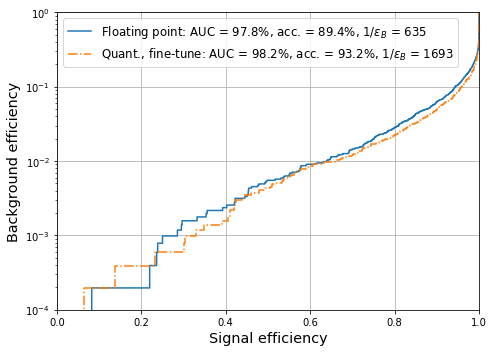

In [8]:
plot_results(results_dir)